##Install library and import it

In [1]:
!pip install -q tensorflow

In [2]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

In [3]:
cd "/content/drive/MyDrive/Colab Notebooks/Cellula Technologies/FirstWeek"

/content/drive/MyDrive/Colab Notebooks/Cellula Technologies/FirstWeek


In [4]:
ls

folder/                     Teeth_Dataset/
Teeth_classification.ipynb  Teeth_Dataset_Augmentation/


##Augmentation images

In [5]:
Data_folder = "Teeth_Dataset"
Aug_folder = "Teeth_Dataset_Augmentation"

In [6]:
main_subfolders = ["Testing", "Training", "Validation"]
for main_folder in main_subfolders:
    main_input_path = os.path.join(Data_folder, main_folder)
    main_output_path = os.path.join(Aug_folder, main_folder)

    print(f"Processing main folder: {main_input_path}")

    if not os.path.exists(main_output_path):
        os.makedirs(main_output_path)

    try:
        class_folders = [d for d in os.listdir(main_input_path) if os.path.isdir(os.path.join(main_input_path, d))]
        print(f"Found {len(class_folders)} class subfolders in {main_folder}: {class_folders}")
    except FileNotFoundError:
        print(f"Error: Main folder not found: {main_input_path}")
        continue


    for class_folder in class_folders:
        class_input_path = os.path.join(main_input_path, class_folder)
        class_output_path = os.path.join(main_output_path, class_folder)

        print(f"  Processing class subfolder: {class_input_path}")

        if not os.path.exists(class_output_path):
            os.makedirs(class_output_path)

        try:
            image_files = [f for f in os.listdir(class_input_path) if os.path.isfile(os.path.join(class_input_path, f))]
            print(f"  Found {len(image_files)} images in {class_folder}")
        except FileNotFoundError:
            print(f"  Error: Class subfolder not found: {class_input_path}")
            continue


        for image_file in image_files:
            image_path = os.path.join(class_input_path, image_file)

            print(f"    Processing image: {image_path}")

            try:
                image_raw = tf.io.read_file(image_path)
                image_tensor = tf.image.decode_image(image_raw, channels=3)
                image_tensor = tf.image.convert_image_dtype(image_tensor, dtype=tf.float32)
            except Exception as e:
                print(f"    Error loading image {image_file} in {main_folder}/{class_folder}: {e}")
                continue


            flipped_horizontally = tf.image.flip_left_right(image_tensor)
            flipped_vertically = tf.image.flip_up_down(image_tensor)

            rotated_90 = tf.image.rot90(image_tensor, k=1)
            rotated_180 = tf.image.rot90(image_tensor, k=2)
            rotated_270 = tf.image.rot90(image_tensor, k=3)

            clipped_image = tf.clip_by_value(image_tensor, clip_value_min=0., clip_value_max=1.)


            base_name, ext = os.path.splitext(image_file)

            image_tensor_uint8 = tf.image.convert_image_dtype(image_tensor, dtype=tf.uint8).numpy()
            flipped_horizontally_uint8 = tf.image.convert_image_dtype(flipped_horizontally, dtype=tf.uint8).numpy()
            flipped_vertically_uint8 = tf.image.convert_image_dtype(flipped_vertically, dtype=tf.uint8).numpy()
            rotated_90_uint8 = tf.image.convert_image_dtype(rotated_90, dtype=tf.uint8).numpy()
            rotated_180_uint8 = tf.image.convert_image_dtype(rotated_180, dtype=tf.uint8).numpy()
            rotated_270_uint8 = tf.image.convert_image_dtype(rotated_270, dtype=tf.uint8).numpy()
            clipped_image_uint8 = tf.image.convert_image_dtype(clipped_image, dtype=tf.uint8).numpy()


            plt.imsave(os.path.join(class_output_path, f"{base_name}_original{ext}"), image_tensor_uint8)
            plt.imsave(os.path.join(class_output_path, f"{base_name}_flipped_h{ext}"), flipped_horizontally_uint8)
            plt.imsave(os.path.join(class_output_path, f"{base_name}_flipped_v{ext}"), flipped_vertically_uint8)
            plt.imsave(os.path.join(class_output_path, f"{base_name}_rotated_90{ext}"), rotated_90_uint8)
            plt.imsave(os.path.join(class_output_path, f"{base_name}_rotated_180{ext}"), rotated_180_uint8)
            plt.imsave(os.path.join(class_output_path, f"{base_name}_rotated_270{ext}"), rotated_270_uint8)
            plt.imsave(os.path.join(class_output_path, f"{base_name}_clipped{ext}"), clipped_image_uint8)


print("Image augmentation and saving complete.")

Processing main folder: Teeth_Dataset/Testing
Found 7 class subfolders in Testing: ['OLP', 'OC', 'MC', 'OT', 'Gum', 'CaS', 'CoS']
  Processing class subfolder: Teeth_Dataset/Testing/OLP
  Found 180 images in OLP
    Processing image: Teeth_Dataset/Testing/OLP/p_1217.jpg


KeyboardInterrupt: 

##Display counting of images each class

In [7]:
(os.listdir("Teeth_Dataset/Training"))

['CaS', 'CoS', 'MC', 'Gum', 'OC', 'OLP', 'OT']

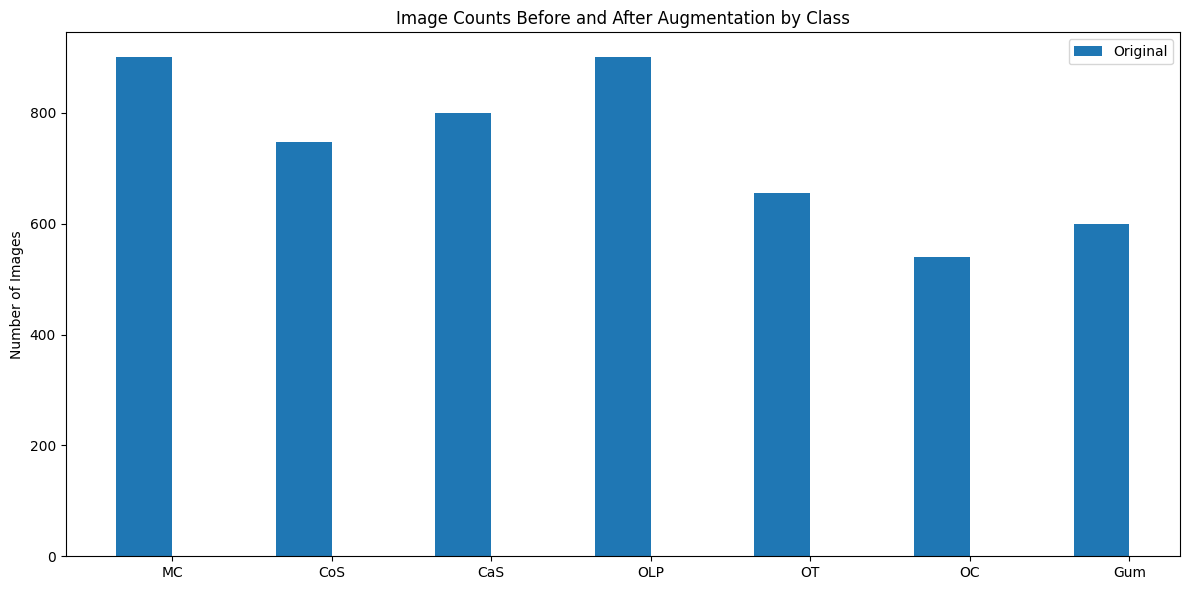

In [8]:
Classes = ['MC', 'CoS', 'CaS', 'OLP', 'OT', 'OC', 'Gum']
original_counts = []

for N in Classes:
    original_count = len(os.listdir(f"Teeth_Dataset/Testing/{N}")) + len(os.listdir(f"Teeth_Dataset/Training/{N}")) + len(os.listdir(f"Teeth_Dataset/Validation/{N}"))
    original_counts.append(original_count)

x = np.arange(len(Classes))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
plt.bar(x - width/2, original_counts, width, label='Original')

ax.set_ylabel('Number of Images')
ax.set_title('Image Counts Before and After Augmentation by Class')
ax.set_xticks(x)
ax.set_xticklabels(Classes)
ax.legend()

fig.tight_layout()

plt.show()

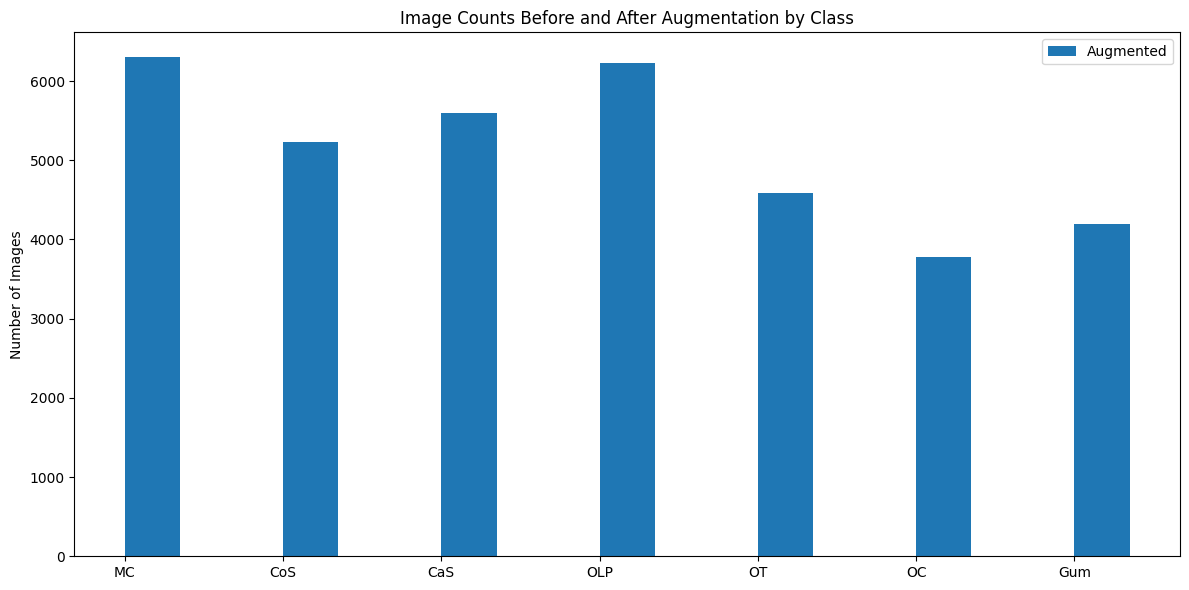

In [9]:
Classes = ['MC', 'CoS', 'CaS', 'OLP', 'OT', 'OC', 'Gum']
augmented_counts = []

for N in Classes:
    augmented_count = len(os.listdir(f"Teeth_Dataset_Augmentation/Testing/{N}")) + len(os.listdir(f"Teeth_Dataset_Augmentation/Training/{N}")) + len(os.listdir(f"Teeth_Dataset_Augmentation/Validation/{N}"))
    augmented_counts.append(augmented_count)

x = np.arange(len(Classes))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
plt.bar(x + width/2, augmented_counts, width, label='Augmented')

ax.set_ylabel('Number of Images')
ax.set_title('Image Counts Before and After Augmentation by Class')
ax.set_xticks(x)
ax.set_xticklabels(Classes)
ax.legend()

fig.tight_layout()

plt.show()

##selected original images and augmntation image to display it


In [11]:
import random
selected_original_images = {}
for class_name in Classes:
    original_class_path = os.path.join(Data_folder, "Training", class_name)
    try:
        original_images = os.listdir(original_class_path)
        if original_images:
            selected_image_name = random.choice(original_images)
            selected_original_images[class_name] = selected_image_name
        else:
            print(f"No images found in original training folder for class {class_name}")
    except FileNotFoundError:
        print(f"Original training folder not found for class {class_name}")


In [12]:
augmented_images_for_original = {}

for class_name, original_image_name in selected_original_images.items():
    augmented_class_path = os.path.join(Aug_folder, "Training", class_name)
    try:
        augmented_images = os.listdir(augmented_class_path)
        base_name, ext = os.path.splitext(original_image_name)
        corresponding_augmented = [f for f in augmented_images if base_name in f]
        augmented_images_for_original[original_image_name] = corresponding_augmented
    except FileNotFoundError:
        print(f"Augmented training folder not found for class {class_name}")
    except Exception as e:
        print(f"Error processing augmented images for class {class_name}: {e}")


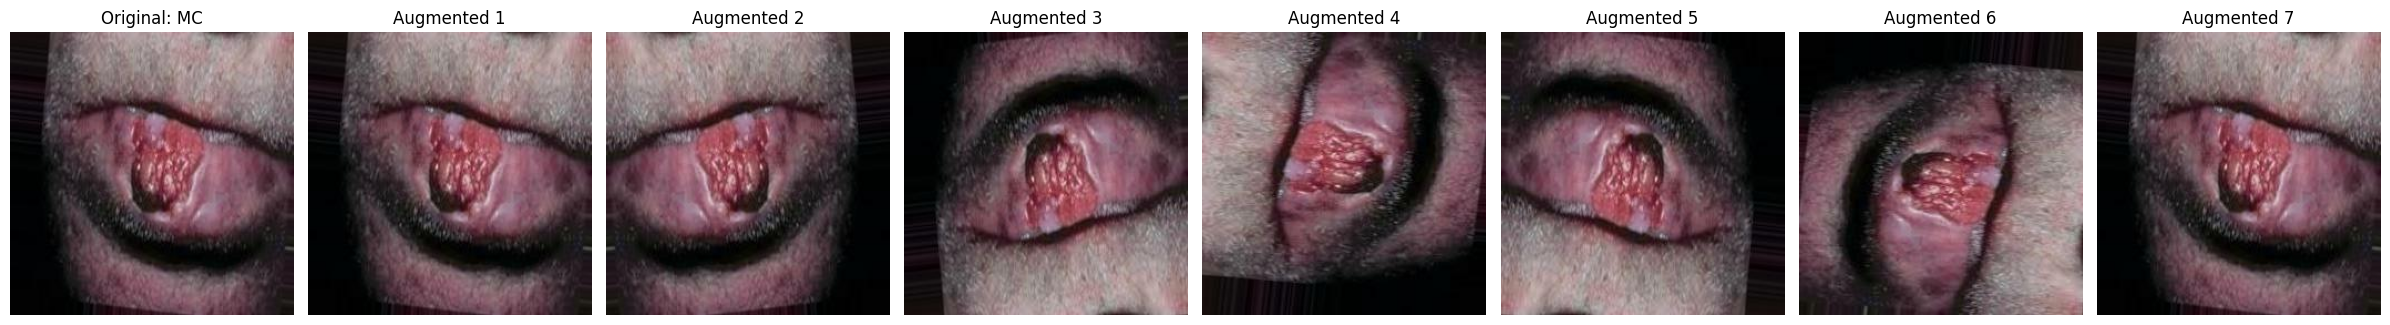

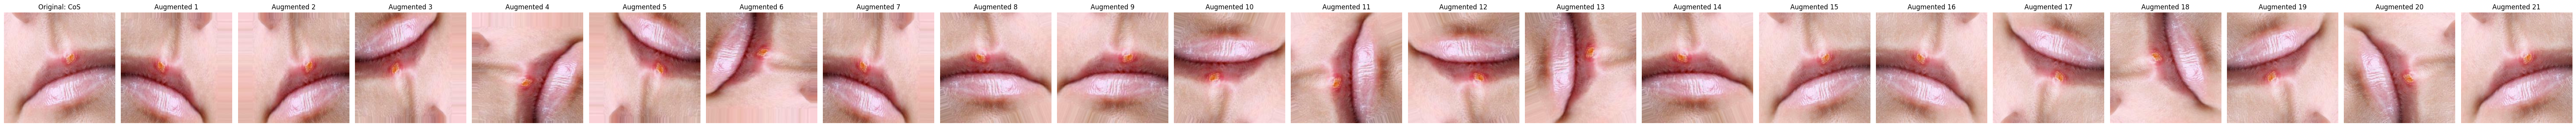

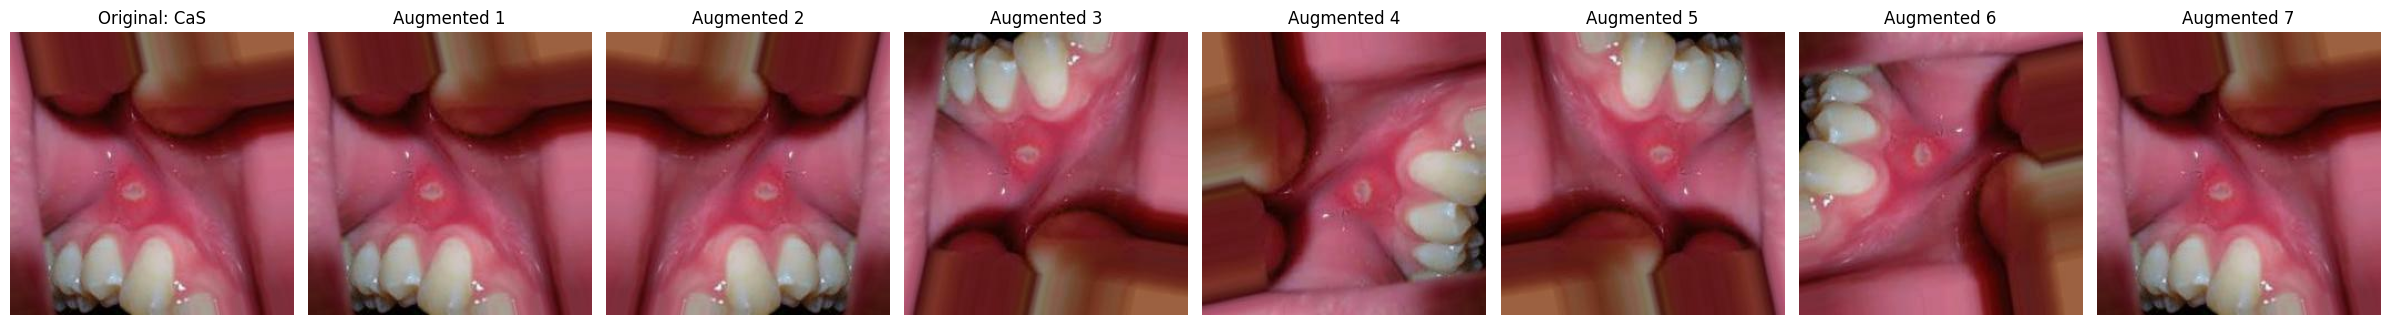

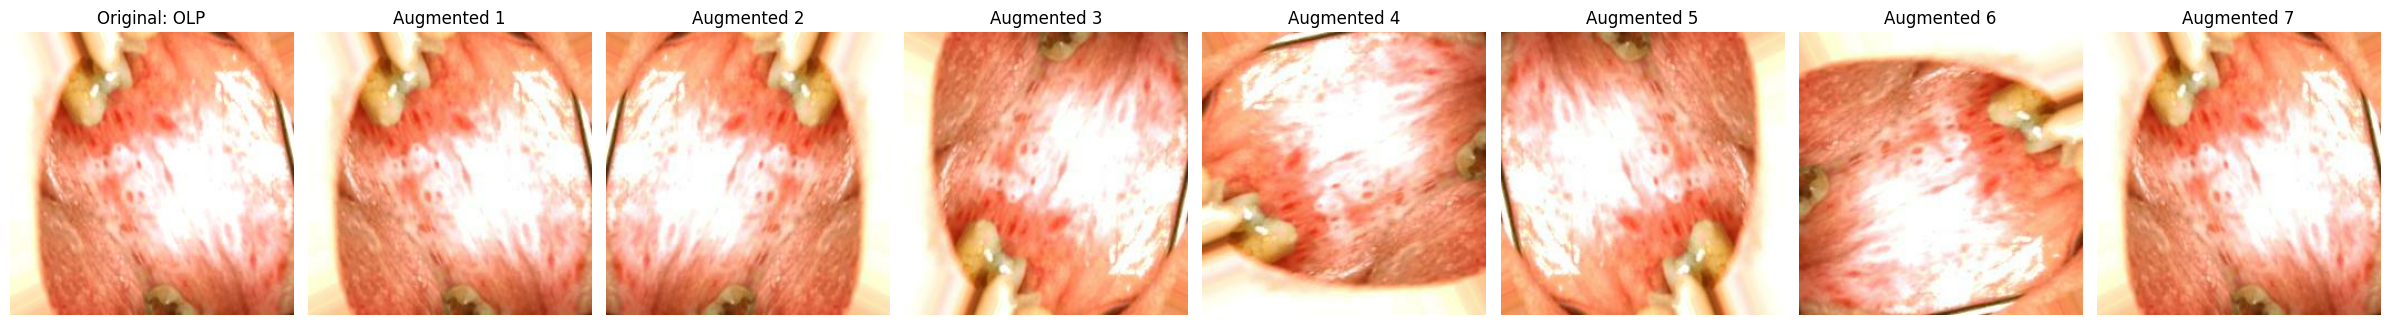

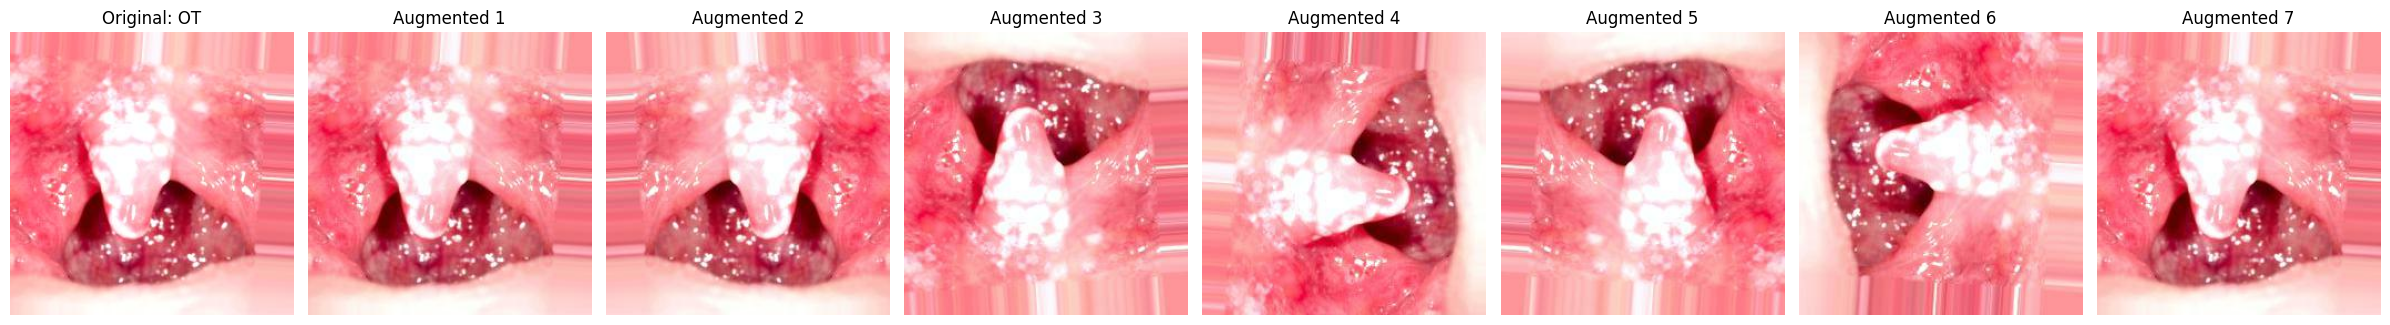

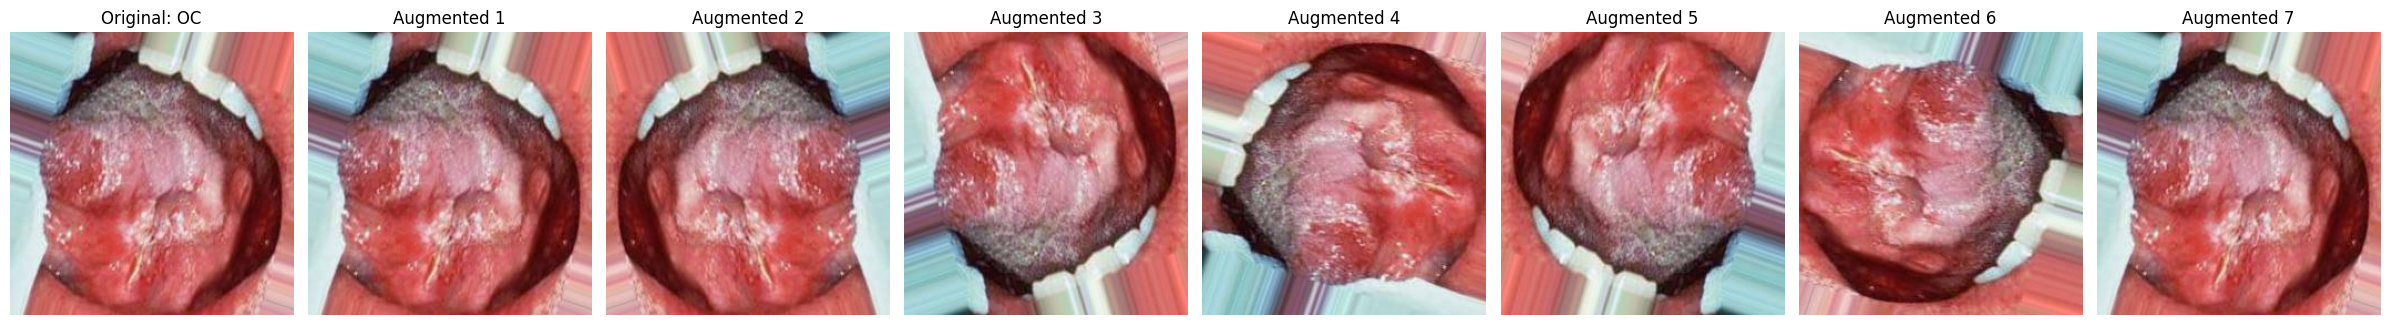

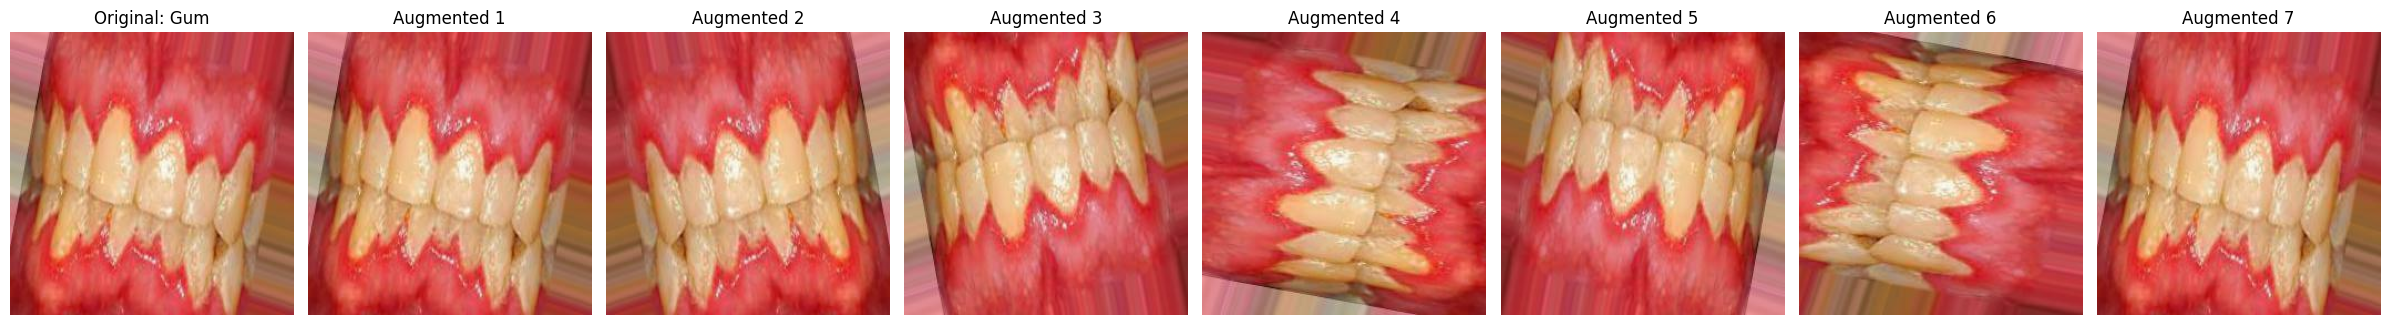

In [13]:
for class_name, original_image_name in selected_original_images.items():
    original_image_path = os.path.join(Data_folder, "Training", class_name, original_image_name)
    augmented_image_names = augmented_images_for_original.get(original_image_name, [])

    num_augmented_images = len(augmented_image_names)
    total_images = num_augmented_images + 1
    fig, axes = plt.subplots(1, total_images, figsize=(total_images * 3, 4))

    try:
        original_img = tf.keras.utils.load_img(original_image_path)
        axes[0].imshow(original_img)
        axes[0].set_title(f"Original: {class_name}")
        axes[0].axis('off')
    except FileNotFoundError:
        print(f"Original image not found: {original_image_path}")
        continue
    except Exception as e:
        print(f"Error loading original image {original_image_name} for class {class_name}: {e}")
        axes[0].set_title(f"Error: {class_name}")
        axes[0].axis('off')
    for j, augmented_image_name in enumerate(augmented_image_names):
        augmented_image_path = os.path.join(Aug_folder, "Training", class_name, augmented_image_name)
        try:
            augmented_img = tf.keras.utils.load_img(augmented_image_path)
            axes[j + 1].imshow(augmented_img)
            axes[j + 1].set_title(f"Augmented {j+1}")
            axes[j + 1].axis('off')
        except FileNotFoundError:
            print(f"Augmented image not found: {augmented_image_path}")
            axes[j + 1].set_title(f"Error {j+1}")
            axes[j + 1].axis('off')
        except Exception as e:
            print(f"Error loading augmented image {augmented_image_name} for class {class_name}: {e}")
            axes[j + 1].set_title(f"Error {j+1}")
            axes[j + 1].axis('off')


    plt.tight_layout()
    plt.show()

##Split data to model

In [14]:
image_size = (258, 258)
batch_size = 32

train_directory = os.path.join(Data_folder, "Training")
val_directory = os.path.join(Data_folder, "Validation")
test_directory = os.path.join(Data_folder, "Testing")


train_ds = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False
)

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

print("Datasets created and prefetched.")

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Datasets created and prefetched.


##Build model and train it


In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(258, 258, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax') ])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,856,391 (56.67 MB)

 Trainable params: 14,856,391 (56.67 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=15)

Epoch 1/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 596s 6s/step - accuracy: 0.1627 - loss: 50.6375 - val_accuracy: 0.2724 - val_loss: 1.8724
Epoch 2/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 544s 5s/step - accuracy: 0.2638 - loss: 1.8227 - val_accuracy: 0.2909 - val_loss: 1.8259
Epoch 3/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 527s 5s/step - accuracy: 0.3432 - loss: 1.7302 - val_accuracy: 0.2928 - val_loss: 1.8291
Epoch 4/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 497s 5s/step - accuracy: 0.3963 - loss: 1.6037 - val_accuracy: 0.3093 - val_loss: 1.9245
Epoch 5/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 538s 5s/step - accuracy: 0.4803 - loss: 1.4287 - val_accuracy: 0.2947 - val_loss: 1.9760
Epoch 6/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 523s 5s/step - accuracy: 0.5405 - loss: 1.2861 - val_accuracy: 0.3142 - val_loss: 2.1985
Epoch 7/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 532s 5s/step - accuracy: 0.6223 - loss: 1.1169 - val_accuracy: 0.3132 - val_loss: 2.2331
Epoch 8/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 528s 5s/step - accuracy: 0.6484 - loss: 1.0258 - val_accuracy: 0.3463 - 

##Evaluate model

In [17]:
loss, accuracy = model.evaluate(test_ds)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 168s 5s/step - accuracy: 0.3763 - loss: 2.8735
Test Loss: 3.1832363605499268
Test Accuracy: 0.34143969416618347


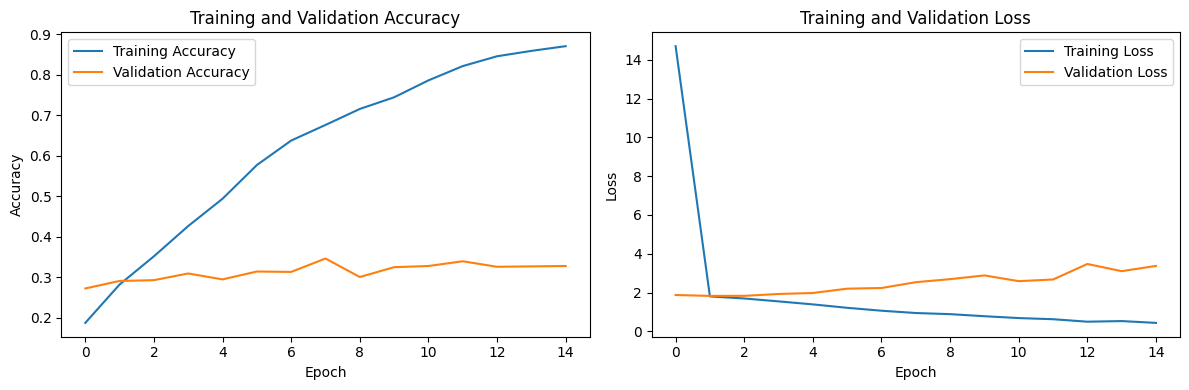

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()